In [1]:
import pandas as pd
import numpy as np
import math
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from decimal import Decimal
from matplotlib.colors import BoundaryNorm
import pingouin as pg
import scikit_posthocs as sp
from statannot import add_stat_annotation

from statannotations.Annotator import Annotator

from scipy import stats
import statsmodels.stats.multitest
from decimal import Decimal

from sklearn import preprocessing

import pickle 
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from decimal import Decimal

import utils_statistics, utils_plotting

# 1. Data I/O

In [3]:
features_clinical        = ['age_onset', 'disease_duration', 'phenotype', 'main_body_part',
                            'main_body_part_pattern', 'secondary_body_part',
                            'secondary_body_part_pattern', 'pre_DBS_cranial', 'pre_DBS_RA',
                            'pre_DBS_LA', 'pre_DBS_UPPER', 'pre_DBS_RL', 'pre_DBS_LL',
                            'pre_DBS_LOWER', 'pre_DBS_R_EXTREM', 'pre_DBS_L_EXTREM',
                            'pre_DBS_cervical', 'pre_DBS_trunk', 'BFMDRS_score']

features_clinical_numeric = ['age_onset', 'disease_duration', 'BFMDRS_score']

features_neural           = ['firing_rate', 'firing_regularity', 'cv', 'lv', 'isi_mean', 'isi_std',
                             'isi_skewness', 'isi_rho', 'pause_index', 'pause_ratio',
                             'asymmetry_index', 'burst_index', 'burst_average_spikes',
                             'burst_spike_proportion', 'burst_duration', 'inter_burst_duration',
                             'burst_freq', 'burst_count', 'pause_freq', 'pause_duration',
                             'pause_time_proportion', 'pause_spike_proportion', 'pause_count',
                             'oscillation_frequency_delta_band', 'oscillation_frequency_theta_band',
                             'oscillation_frequency_alpha_band', 'oscillation_frequency_beta_band',
                             'oscillation_frequency_gamma_band', 'is_bursting', 'is_tonic',
                             'is_irregular', 'delta_band_oscillatory', 'theta_band_oscillatory',
                             'alpha_band_oscillatory', 'beta_band_oscillatory',
                             'gamma_band_oscillatory', 'is_oscillatory']

features_neural_tot       = ['patient','firing_rate', 'firing_regularity', 'cv', 'lv', 'isi_mean', 'isi_std',
                             'isi_skewness', 'isi_rho', 'pause_index', 'pause_ratio',
                             'asymmetry_index', 'burst_index', 'burst_average_spikes',
                             'burst_spike_proportion', 'burst_duration', 'inter_burst_duration',
                             'burst_freq', 'burst_count', 'pause_freq', 'pause_duration',
                             'pause_time_proportion', 'pause_spike_proportion', 'pause_count',
                             'oscillation_frequency_delta_band', 'oscillation_frequency_theta_band',
                             'oscillation_frequency_alpha_band', 'oscillation_frequency_beta_band',
                             'oscillation_frequency_gamma_band', 'is_bursting', 'is_tonic',
                             'is_irregular', 'delta_band_oscillatory', 'theta_band_oscillatory',
                             'alpha_band_oscillatory', 'beta_band_oscillatory',
                             'gamma_band_oscillatory', 'is_oscillatory']

features_numeric          = ['age_onset', 'disease_duration', 'BFMDRS_score',
                             'firing_rate', 'firing_regularity', 'cv', 'lv', 'isi_mean', 'isi_std',
                             'isi_skewness', 'isi_rho', 'pause_index', 'pause_ratio',
                             'asymmetry_index', 'burst_index', 'burst_average_spikes',
                             'burst_spike_proportion', 'burst_duration', 'inter_burst_duration',
                             'burst_freq', 'burst_count', 'pause_freq', 'pause_duration',
                             'pause_time_proportion', 'pause_spike_proportion', 'pause_count',
                             'oscillation_frequency_delta_band', 'oscillation_frequency_theta_band',
                             'oscillation_frequency_alpha_band', 'oscillation_frequency_beta_band',
                             'oscillation_frequency_gamma_band', 'is_bursting', 'is_tonic',
                             'is_irregular', 'delta_band_oscillatory', 'theta_band_oscillatory',
                             'alpha_band_oscillatory', 'beta_band_oscillatory',
                             'gamma_band_oscillatory', 'is_oscillatory']


In [5]:
neural_data         = pd.read_csv('dataset/genetic_dystonia_pallidal_neuron_activity.csv')
neural_data         = neural_data[neural_data.patient!="patient1"] # removing benign-SGCE case

neural_data         = neural_data[features_neural_tot]
neural_data_mean    = neural_data.groupby('patient').mean()
neural_data_mean.sort_index(inplace=True)

# represent a fraction of neurons as percentages
neural_data_mean.is_bursting            = neural_data_mean.is_bursting * 100
neural_data_mean.is_tonic               = neural_data_mean.is_tonic * 100
neural_data_mean.is_irregular           = neural_data_mean.is_irregular * 100
neural_data_mean.delta_band_oscillatory = neural_data_mean.delta_band_oscillatory * 100
neural_data_mean.theta_band_oscillatory = neural_data_mean.theta_band_oscillatory * 100
neural_data_mean.alpha_band_oscillatory = neural_data_mean.alpha_band_oscillatory * 100
neural_data_mean.beta_band_oscillatory  = neural_data_mean.beta_band_oscillatory * 100
neural_data_mean.gamma_band_oscillatory = neural_data_mean.gamma_band_oscillatory * 100
neural_data_mean.is_oscillatory         = neural_data_mean.is_oscillatory * 100

In [7]:
clinical_data       = pd.read_csv('dataset/clinical_data.csv')
clinical_data       = clinical_data[clinical_data.patient!="patient1"] # removing benign-SGCE case

clinical_data.index = clinical_data.patient
clinical_data.drop(["patient"], axis=1, inplace=True)
clinical_data.sort_index(inplace=True)

dataset = pd.merge(clinical_data, neural_data_mean, on="patient")
dataset.fillna(0, inplace=True)

clinical_data       = clinical_data[['gene','age_onset', 'disease_duration', 'BFMDRS_score']]
gene_groups_burst   = {"AOPEP" :"L", "PANK2" :"L", "THAP1" :"L","VPS16" :"L", "TOR1A" :"L", 
                       "GNAL"  :"H", "SGCE"  :"H", "KMT2B" :"H", "PLA2G6":"H"} 
gene_groups_reg     = {"AOPEP" :"H", "PANK2" :"H", "THAP1" :"H",
                       "VPS16" :"L", "TOR1A" :"L", "GNAL"  :"L", "SGCE"  :"L", "KMT2B" :"L", "PLA2G6":"L"} 
clinical_data["group_burst"]      = clinical_data.gene.map(gene_groups_burst).to_list()
clinical_data["group_regularity"] = clinical_data.gene.map(gene_groups_reg).to_list()

# 2. Correlation Analyses

In [10]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compare_clinical_features(data, features, group_column):
   
    p_values           = []
    comparison_results = []
    
    for feature in features:
        group_L = data[data[group_column] == 'L'][feature]
        group_H = data[data[group_column] == 'H'][feature]
        
        stat, p = mannwhitneyu(group_L, group_H, alternative='two-sided')
        p_values.append(p)
        comparison_results.append({
            'feature': feature,
            'statistic': stat,
            'p_value': p
        })

    _, corrected_p_values, _, _ = multipletests(p_values, method='holm')

    for i, result in enumerate(comparison_results):
        result['p_value_corrected'] = corrected_p_values[i]

    results_df = pd.DataFrame(comparison_results)
    return results_df


def plot_inter_group_comparison(dataset, group, parameters, title, order, axs):
    
    colors    = ["#d5756e","#55b155"]
    box_pairs = [(a, b) for idx, a in enumerate(list(dataset[group].unique())) 
                 for b in list(dataset[group].unique())[idx + 1:]]
    
    print(box_pairs)
    
    for i, param in enumerate(parameters):

        ax = sns.boxplot(data = dataset, x = group, y = param, boxprops=dict(lw = 0.5, edgecolor = 'dimgray'), fliersize = 0, 
                        palette = colors, medianprops = {'lw':0.5,'color':'dimgray'},whiskerprops = dict(alpha=1, lw = 0.5, color = 'dimgray'),
                        capprops = dict(alpha=1, lw = 0.5, color = 'dimgray'), order = order, ax = axs[i])

        ax = sns.stripplot(data = dataset, x = group, y = param, ax = ax, edgecolor='dimgray',  linewidth = 0.5, s=2,
                           palette = colors, order = order)

        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(param, fontsize = 6)

[('L', 'H')]
[('H', 'L')]


<Figure size 640x480 with 0 Axes>

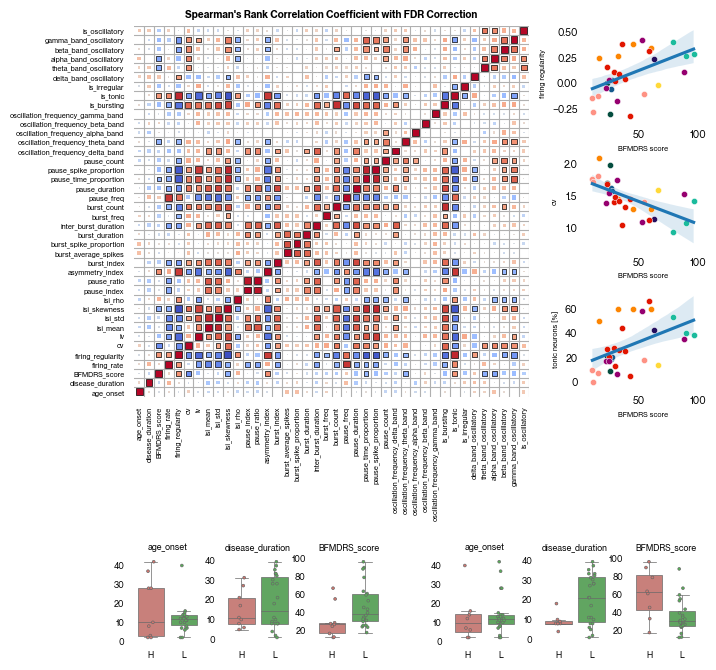

In [12]:
gene_colors           = {}
gene_colors["AOPEP"]  = "#240E5E"
gene_colors["GNAL"]   = "#044D3E"
gene_colors["KMT2B"]  = "#155A8D"
gene_colors["PANK2"]  = "#1BBB9D"
gene_colors["PLA2G6"] = "#FFD939" 
gene_colors["SGCE"]   = "#FE9284"
gene_colors["THAP1"]  = "#FC8502"
gene_colors["TOR1A"]  = "#E11500"
gene_colors["VPS16"]  = "#95006F"

plt.rc('font', serif="Neue Haas Grotesk Text Pro")
plt.rcParams['axes.facecolor']='white'
plt.rcParams["font.family"] = "Neue Haas Grotesk Text Pro"

fig = plt.figure()

cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(18.5*cm, 21*cm))
plt.axis('off')

ax_corr  = plt.subplot2grid((60, 50), (0, 0)   , colspan=35, rowspan=35)
ax_line1 = plt.subplot2grid((60, 50), (0, 40)  , colspan=20, rowspan=9)
ax_line2 = plt.subplot2grid((60, 50), (12, 40) , colspan=20, rowspan=9)
ax_line3 = plt.subplot2grid((60, 50), (25, 40) , colspan=20, rowspan=9)

ax_com11 = plt.subplot2grid((60, 50), (50, 0)  , colspan=6, rowspan=8)
ax_com12 = plt.subplot2grid((60, 50), (50, 8) , colspan=6, rowspan=8)
ax_com13 = plt.subplot2grid((60, 50), (50, 16) , colspan=6, rowspan=8)

ax_com21 = plt.subplot2grid((60, 50), (50, 28)  , colspan=6, rowspan=8)
ax_com22 = plt.subplot2grid((60, 50), (50, 36) , colspan=6, rowspan=8)
ax_com23 = plt.subplot2grid((60, 50), (50, 44) , colspan=6, rowspan=8)

ax_corr, corr  = utils_plotting.plot_corr_matrix(dataset, features_numeric, palette="coolwarm", ax=ax_corr, p_adjust="FDR")
ax_corr.set_title('Spearman\'s Rank Correlation Coefficient with FDR Correction', weight = 'bold', fontsize = 7)

ax_line1 = utils_plotting.plot_corr_line(dataset, feat_x="BFMDRS_score", feat_y="firing_regularity", size=20, ax=ax_line1)
ax_line1.set_xlabel("BFMDRS score", fontsize=5)
ax_line1.set_ylabel("firing regularity", fontsize=5)

ax_line2 = utils_plotting.plot_corr_line(dataset, feat_x="BFMDRS_score", feat_y="cv", size=20, ax=ax_line2)
ax_line2.set_xlabel("BFMDRS score", fontsize=5)
ax_line2.set_ylabel("cv", fontsize=5)

ax_line3 = utils_plotting.plot_corr_line(dataset, feat_x="BFMDRS_score", feat_y="is_tonic", size=20, ax=ax_line3)
ax_line3.set_xlabel("BFMDRS score", fontsize=5)
ax_line3.set_ylabel("tonic neurons [%]", fontsize=5)

#############################################################################################################
order      = ["H", "L"]
parameters = ["age_onset","disease_duration","BFMDRS_score"]
plot_inter_group_comparison(clinical_data, group="group_burst", parameters=parameters, title="", order=order, axs=[ax_com11,ax_com12,ax_com13])

order      = ["H","L"]
parameters = ["age_onset","disease_duration","BFMDRS_score"]
plot_inter_group_comparison(clinical_data, group="group_regularity", parameters=parameters, title="", order=order, axs=[ax_com21,ax_com22,ax_com23])

plt.savefig("figures/Figure 4.svg", dpi=300)

In [13]:
corr = utils_statistics.measure_spearman_corr(dataset, features_numeric, p_adjust="FDR")

In [14]:
corr[(corr.x == "firing_regularity") & (corr.y == "BFMDRS_score")]

,x,y,value,p
84,firing_regularity,BFMDRS_score,0.532715,0.009063


In [15]:
corr[(corr.x == "cv") & (corr.y == "BFMDRS_score")]

,x,y,value,p
85,cv,BFMDRS_score,-0.6914,0.000155


In [16]:
corr[(corr.x == "is_tonic") & (corr.y == "BFMDRS_score")]

,x,y,value,p
112,is_tonic,BFMDRS_score,0.509482,0.014178


In [17]:
compare_clinical_features(clinical_data, features=['age_onset', 'disease_duration', 'BFMDRS_score'], group_column='group_burst')

,feature,statistic,p_value,p_value_corrected
0,age_onset,96.5,0.930409,1.000000
1,disease_duration,114.0,0.526347,1.000000
2,BFMDRS_score,147.0,0.038698,0.116095


In [19]:
compare_clinical_features(clinical_data, features=['age_onset', 'disease_duration', 'BFMDRS_score'], group_column='group_regularity')

,feature,statistic,p_value,p_value_corrected
0,age_onset,105.0,0.571261,0.571261
1,disease_duration,139.5,0.033138,0.066276
2,BFMDRS_score,39.0,0.017772,0.053316


In [26]:
# 3. High Tonicity vs Low

,gene,age_onset,disease_duration,BFMDRS_score,group_burst,group_regularity
patient,,,,,,
patient10,THAP1,7,10,32.5,L,H
patient11,THAP1,6,8,45.0,L,H
patient12,THAP1,14,18,60.5,L,H
patient13,PANK2,16,9,89.5,L,H
patient14,KMT2B,28,17,27.0,H,L
patient15,TOR1A,12,33,39.0,L,L
patient16,TOR1A,13,30,29.5,L,L
patient17,TOR1A,7,2,43.0,L,L
patient18,TOR1A,10,39,25.0,L,L
